# Challenge 2: Modeling non-stationarity and finding an equilibrium


## 1. Definition
---

Vector error correlation models are related to vector autoregressive models (VARs). Given a n-dimensional of cointegrated time series $X_t = (X_{1,t}, X_{2,t}, ..., X_{n,t})$ the  VECM is specified as:

$$ \Delta X_t = C + \alpha \beta' X_{t-1} + \sum_{i=1}^{p-1} \Gamma_i \Delta X_{t-i} + \epsilon_t $$

Where 

> $C$ is the deterministic vector or matrix depending if there are constants and/or linear trend <br>
> $\beta$ is the cointegrating vector (long-run equilibrium relationship) <br>
> $\alpha$ speed of adjustment coefficients (how fast variables revert to equilibrium) <br>
> $\Gamma_i$ is a  nXn matrix for coefficients of lagged differences of $X$ (short-term dynamic coefficients) <br>
> $\epsilon_t$ is a white noise nX1 vector with $0$ means and stable covariance <br>

## 2. Description
---

Adjustment vectors contain the coefficients that can bring the short-term deviation of the time series back to their long-term equilibrium relationship. The coefficients in adjustment vectors are error correction coefficients. Therefore, $\Pi = \alpha \beta'$ corrects the error gap that happened in the last period and brings short-term disequilibrium among time series back to their long-term equilibrium.

## 3. Demonstration 
---

In this challenge, we aim to calibrate a Vector Error Correction Model (VECM), which requires the presence of cointegrated time series. As highlighted in the literature, financial time series—particularly stock prices—are often non-stationary but may exhibit long-run equilibrium relationships, making them suitable candidates for cointegration analysis.

For this purpose, we consider daily adjusted stock prices for four major technology companies: Google, Apple, Microsoft, and Nvidia, spanning the period from 2016 to 2021. These firms operate within the same sector and are likely influenced by common macroeconomic and industry-specific factors, which may induce cointegrated behavior among their price series.

---

In [1]:
# Load packages

import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from arch.unitroot import ADF, KPSS 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen


from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams["figure.figsize"] = (16, 9)  # Figure size and width

### 3.1. Fetching data

In [2]:
# Import data
tickers = ['NVDA', 'AAPL', 'GOOGL', "MSFT"]
data = yf.download(tickers, start='2016-01-01', end='2021-12-31')['Close']
data = data.dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


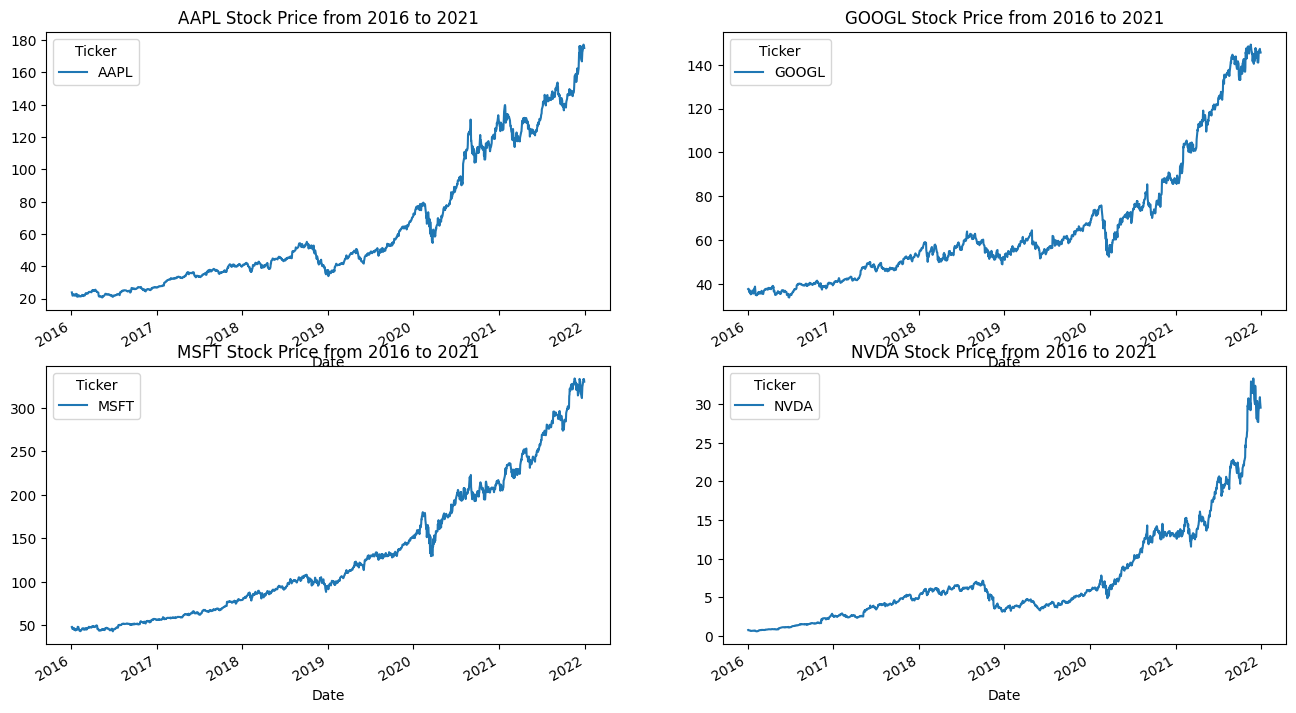

In [3]:
# Stock price from 2016 to 2021
fig, ax = plt.subplots(2, 2)
ax = ax.flatten() 
for i, col in enumerate(data.columns):
    data[[col]].plot(title=f"{col} Stock Price from 2016 to 2021", ax=ax[i])


### 3.2. Testing for stationarity

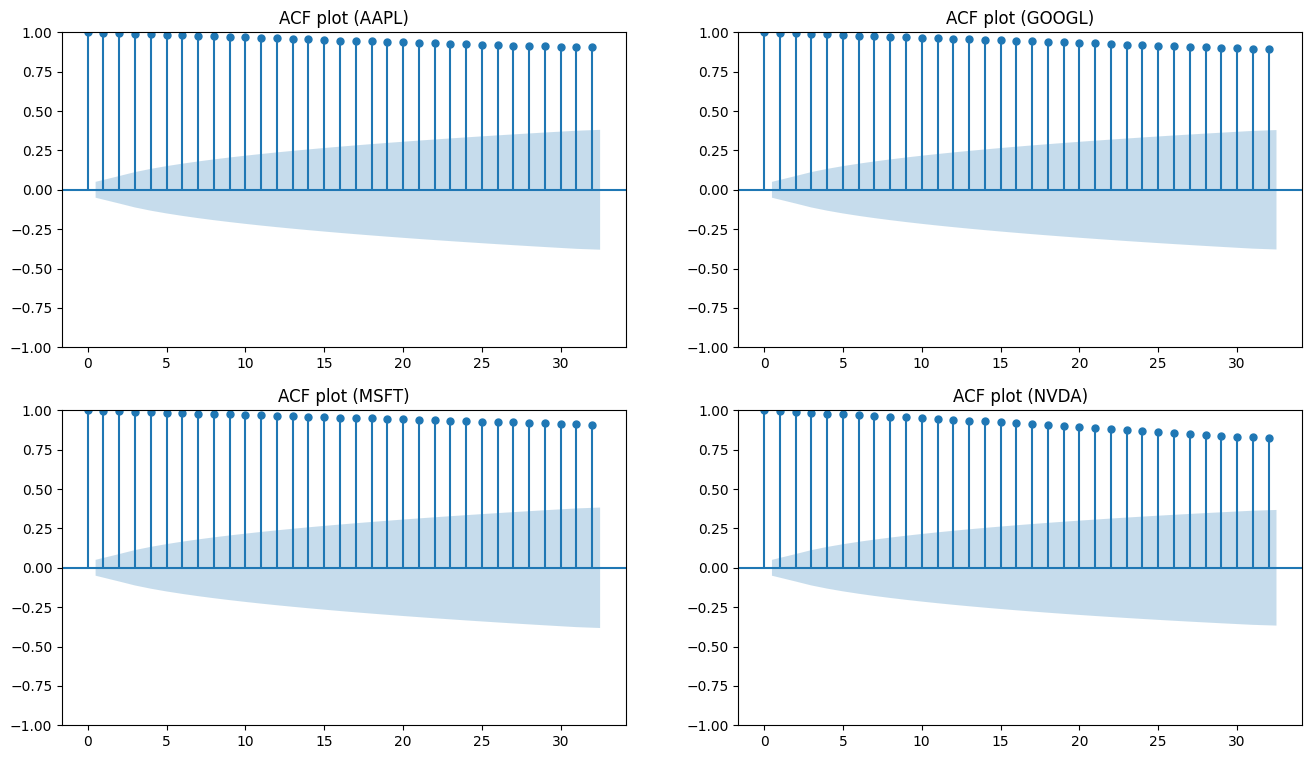

In [4]:
# Stock price ACF
fig, ax = plt.subplots(2, 2)
ax = ax.flatten() 
for i, col in enumerate(data.columns):
    plot_acf(data[col], title=f"ACF plot ({col})", ax=ax[i])


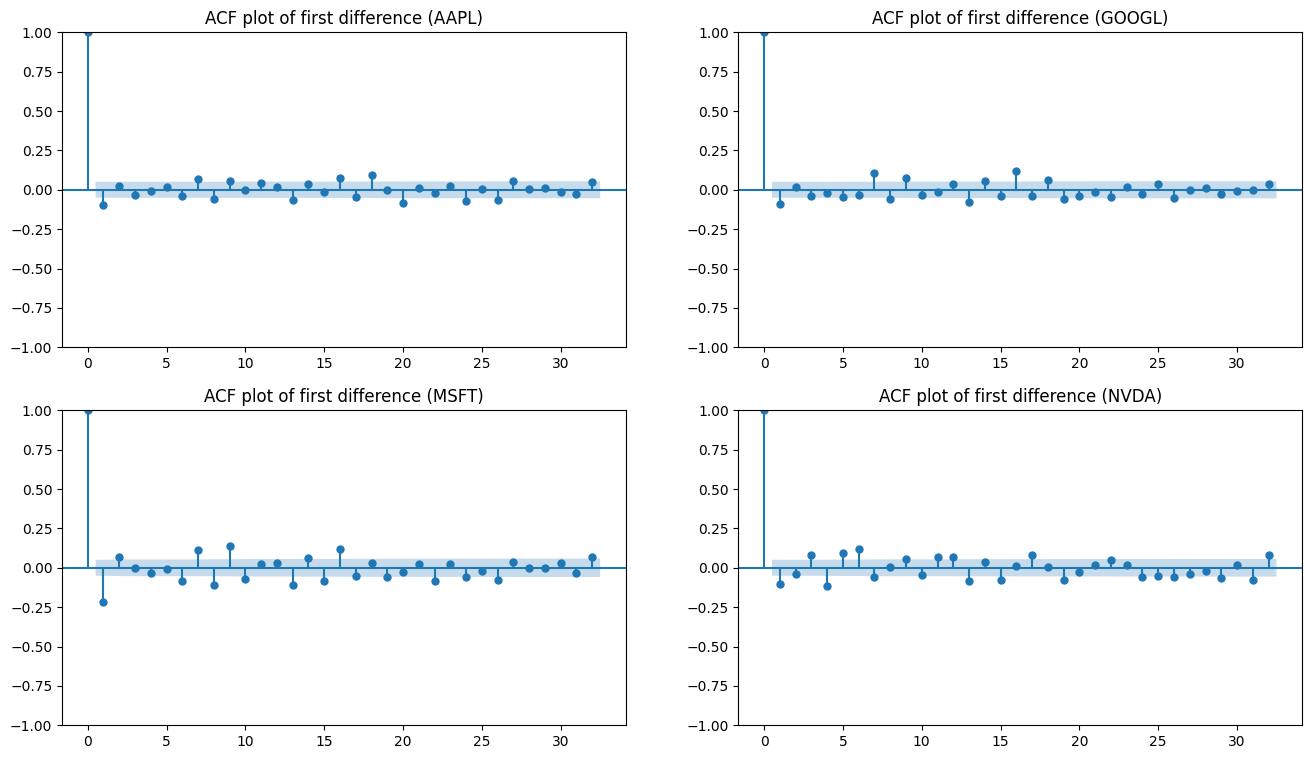

In [5]:
# Stock price ACF
fig, ax = plt.subplots(2, 2)
ax = ax.flatten() 
for i, col in enumerate(data.columns):
    plot_acf(data.diff().dropna()[col], title=f"ACF plot of first difference ({col})", ax=ax[i])


To formally test for stationarity, we often use the Augmented Dickey-Fuller (ADF) test and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

ADF Test hypotheses:
> $H_0$: The time series is non-stationary (unit root)<br>
> $H_1$: The time series is stationary <br>

KPSS Test hypotheses:
> $H_0$: The time series is stationary (around a level or trend)<br>
> $H_1$: The time series is non-stationary<br>

These are complementary tests that have opposite null hypotheses.

Decision rule

|  |  |  |
|:---|:---|:---|
Test | Null hypothesis | Reject $H_0$ if |
ADF | non-stationary | Test stat < critical value |
KPSS | stationary | Test stat > critical value |

In [6]:
# ADF Test Results with 5% Significance Level for GOOGLE, APPLE, NVIDIA, GOLD
def stationary_test(data):
    result_adf = {}
    for i, col in enumerate(data.columns):
        temp = ADF(data[col], trend="n", method="bic")
        temp_kpss = KPSS(data[col], trend="ct", lags=-1)
        
        if temp.stat > temp.critical_values["5%"]:
            temp_diff = ADF(data[[col]].diff().dropna(), trend="n", method="bic")
            temp_kpss_diff = KPSS(data[[col]].diff().dropna(), trend="ct", lags=-1)
            
            if (temp_diff.stat < temp_diff.critical_values["5%"]) and (temp_kpss_diff.stat < temp_kpss_diff.critical_values["5%"]):
                result_adf[col] = (temp.stat, temp_diff.stat, temp.critical_values["5%"],
                                   temp_kpss.stat,  temp_kpss_diff.stat, temp_kpss.critical_values["5%"],
                                   "I(1)")
        elif (temp_kpss.stat < temp_kpss.critical_values["5%"]):
            result_adf[col] = (temp.stat, " " , temp.critical_values["5%"],
                               temp_kpss.stat, " ", temp_kpss.critical_values["5%"],
                               "I(0)")
    return pd.DataFrame(
        result_adf,
        index=["ADF Test Statistic (Level)", "ADF Test Statistic (1st Diff)",  "ADF 5% Critical Value",
               "KPSS Test Statistic (Level)", "KPSS Test Statistic (1st Diff)",  "KPSS 5% Critical Value",
               "Decision"],
        )

stationary_test(data)

,AAPL,GOOGL,MSFT,NVDA
ADF Test Statistic (Level),3.518281,3.044821,4.135635,3.138927
ADF Test Statistic (1st Diff),-42.425611,-42.370805,-47.94415,-13.583355
ADF 5% Critical Value,-1.94118,-1.94118,-1.94118,-1.94118
KPSS Test Statistic (Level),1.294035,1.055377,1.309525,0.994498
KPSS Test Statistic (1st Diff),0.044809,0.080339,0.030492,0.124489
KPSS 5% Critical Value,0.1479,0.1479,0.1479,0.1479
Decision,I(1),I(1),I(1),I(1)


### 3.3. Testing for cointegration
---
Cointegration tests are used to determine whether two or more time series, which are individually I(1), have a long-term equilibrium relationship. This is particularly relevant when analysing technology stock prices, as these stocks may exhibit common trends in the long run, even though their short-term behaviors might diverge due to volatility, market reactions, or other temporary factors.

If time series are cointegrated, it implies that there is a long-term equilibrium relationship between them. In other words, despite short-term fluctuations and individual trends, the series tend to move together over time.


The Johansen cointegration test is one of the most popular methods for testing for cointegration. It provides a framework to test for the number of cointegrating relationships in a multivariate setting. The Johansen test works under the assumption that the time series are I(1) and tests whether there exists a linear combination of these series that is stationary.

One key step in performing the Johansen cointegration test is to specify the number of lags to be used in the Vector Autoregression (VAR) model. The lag length is important because it determines the number of past values of the series included in the model, which influences the dynamics and the results of the cointegration test.

To determine the appropriate number of lags, a lag selection procedure is performed. This is typically done using VAR specification, where the optimal lag length is selected based on various criteria, such as AIC and BIC.

In [7]:
# Selection of Number of Lags for VEC Model

# Fit VAR model and run lag selection tool
model = VAR(data)
x = model.select_order(maxlags=10, trend="c")
x.summary()

d:\deb\ENSAI\cours3A\11. ASSET MANAGEMENT\LAB\Script\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,17.81,17.83,5.452e+07,17.82
1,-1.495,-1.424*,0.2242,-1.469
2,-1.551,-1.423,0.2121,-1.503
3,-1.549,-1.364,0.2125,-1.480
4,-1.571,-1.331,0.2077,-1.482
5,-1.588,-1.291,0.2043,-1.477
6,-1.622,-1.268,0.1974,-1.491
7,-1.681,-1.270,0.1863,-1.528*
8,-1.693*,-1.226,0.1839*,-1.519
9,-1.691,-1.167,0.1844,-1.496


In [8]:
# Cointegration test (Johansen)
def johansen_test(data, lag=1):
    jtest = coint_johansen(data, det_order=0, k_ar_diff=lag)
    # Print the results
    print(f"Eigenvalues of VECM coefficient matrix : {jtest.eig}\n")

    result = pd.DataFrame(
        {
            "Test statistic": jtest.trace_stat,
            "Critical values (90%)": jtest.trace_stat_crit_vals[:, 0],
            "Critical values (95%)": jtest.trace_stat_crit_vals[:, 1],
            "Critical values (99%)": jtest.trace_stat_crit_vals[:, 2],
        },
        index=["rank=0", "rank<=1", "rank<=2", "rank<=3"],
    )
    return result

In [9]:
johansen_test(data, lag=1)

Eigenvalues of VECM coefficient matrix : [0.02012037 0.01370546 0.00474875 0.00013249]



,Test statistic,Critical values (90%),Critical values (95%),Critical values (99%)
rank=0,58.839671,44.4929,47.8545,54.6815
rank<=1,28.188749,27.0669,29.7961,35.4628
rank<=2,7.377982,13.4294,15.4943,19.9349
rank<=3,0.199809,2.7055,3.8415,6.6349


for the first step, we test
> $H_0$: rank = 0 <br>
> $H_1$: rank >= 1 <br>

since the test stat is greater than the critical value (5% significance level), $H_0$ is rejected. There is at least one cointegrating relationship. Thus we move to the second step to test
> $H_0$: rank = 1 <br>
> $H_1$: rank >= 2 <br>

the test stat is lower than the critical value (5% significance level), $H_0$ is not rejected. We conclude that there is exactly one cointegrating relationship.

This means that the stock prices of the companies analyzed have a long-term equilibrium relationship—they are cointegrated with exactly one cointegrating vector.

### 3.4. Calibrating VECM parameters

In [10]:
# VECM model
vecm_model = VECM(endog=data, k_ar_diff=1, deterministic="ci").fit()
print(vecm_model.summary())

d:\deb\ENSAI\cours3A\11. ASSET MANAGEMENT\LAB\Script\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Det. terms outside the coint. relation & lagged endog. parameters for equation AAPL
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.AAPL       -0.0299      0.037     -0.812      0.417      -0.102       0.042
L1.GOOGL       0.0570      0.049      1.161      0.246      -0.039       0.153
L1.MSFT       -0.1050      0.026     -4.037      0.000      -0.156      -0.054
L1.NVDA        0.3324      0.156      2.126      0.033       0.026       0.639
Det. terms outside the coint. relation & lagged endog. parameters for equation GOOGL
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.AAPL       -0.0057      0.029     -0.193      0.847      -0.063       0.052
L1.GOOGL       0.0193      0.039      0.492      0.623      -0.058       0.096
L1.MSFT       -0.0973      0.021     -4.6

### 3.5. Diagnosis

**Long-run equilibrium equation**

$$
S_t = -16.5637 + 1*AAPL_t + 0.6624*GOOGL_t \\
 - 0.5198*MSFT_t - 3.6798*NVDA_t
$$

**Long-run equilibrium stationarity**

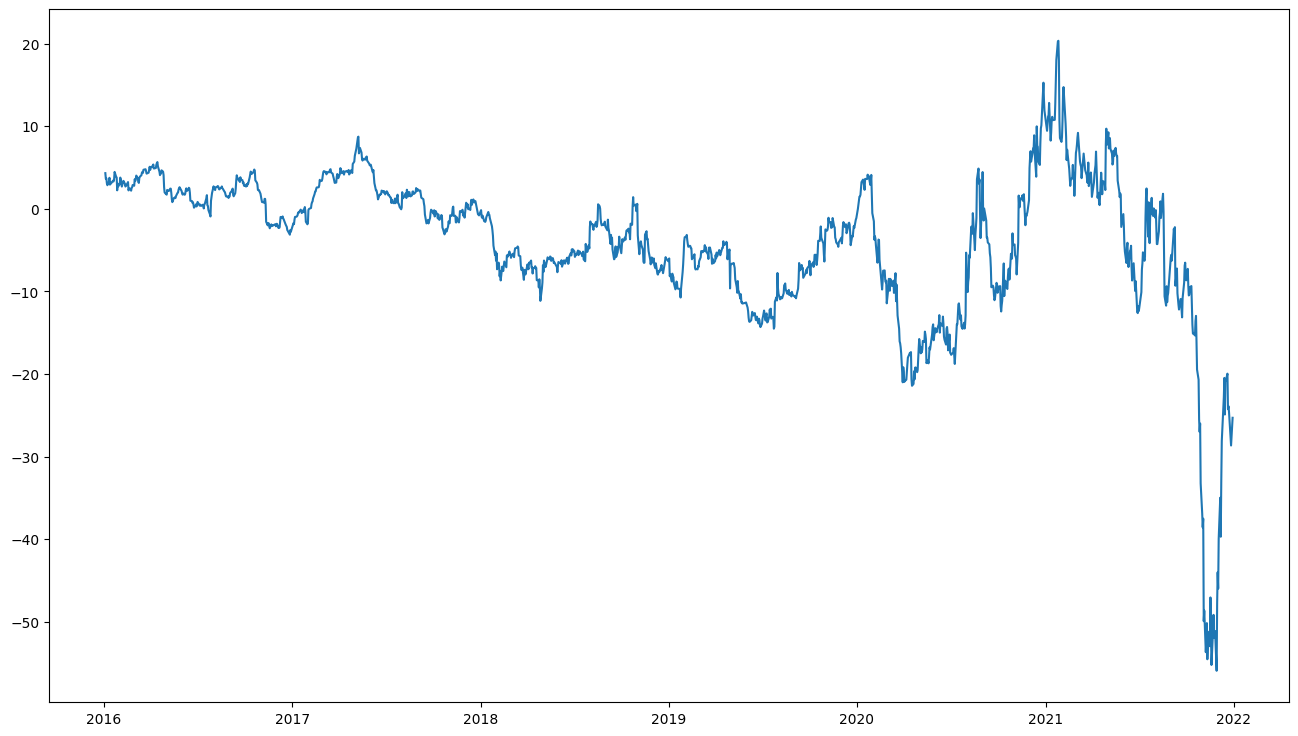

In [11]:
# Time Plot for Deviation from Long-Term Equilibrium
"""
The precise coefficients of the linear combination are in:
vecm_model.const_coint and vecm_model.beta
S = -16.5637 + 1*data.AAPL + 0.6624*data.GOOGL - 0.5198*data.MSFT - 3.6798*data.NVDA
"""
S = (
    vecm_model.const_coint[0][0]
    + vecm_model.beta[0][0] * data["AAPL"]
    + vecm_model.beta[1][0] * data["GOOGL"]
    + vecm_model.beta[2][0] * data["MSFT"]
    + vecm_model.beta[3][0] * data["NVDA"]
)
plt.plot(S)
plt.show()

In [12]:
# ADF Test Result for Deviation from Long-Term Equilibrium
S_adf = ADF(S, trend="n", method="bic")
print("Augmented Dickey-Fuller Unit Root Test\n", S_adf.regression.summary())
print("\nTest statistics and critical values: \n", S_adf)

Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              4.342
Date:                Sun, 06 Apr 2025   Prob (F-statistic):                      0.0373
Time:                        15:46:33   Log-Likelihood:                         -2610.1
No. Observations:                1509   AIC:                                      5222.
Df Residuals:                    1508   BIC:                                      5227.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-

In [13]:
KPSS(S, trend="ct", lags=-1)

Test Statistic,0.159
P-value,0.038
Lags,24


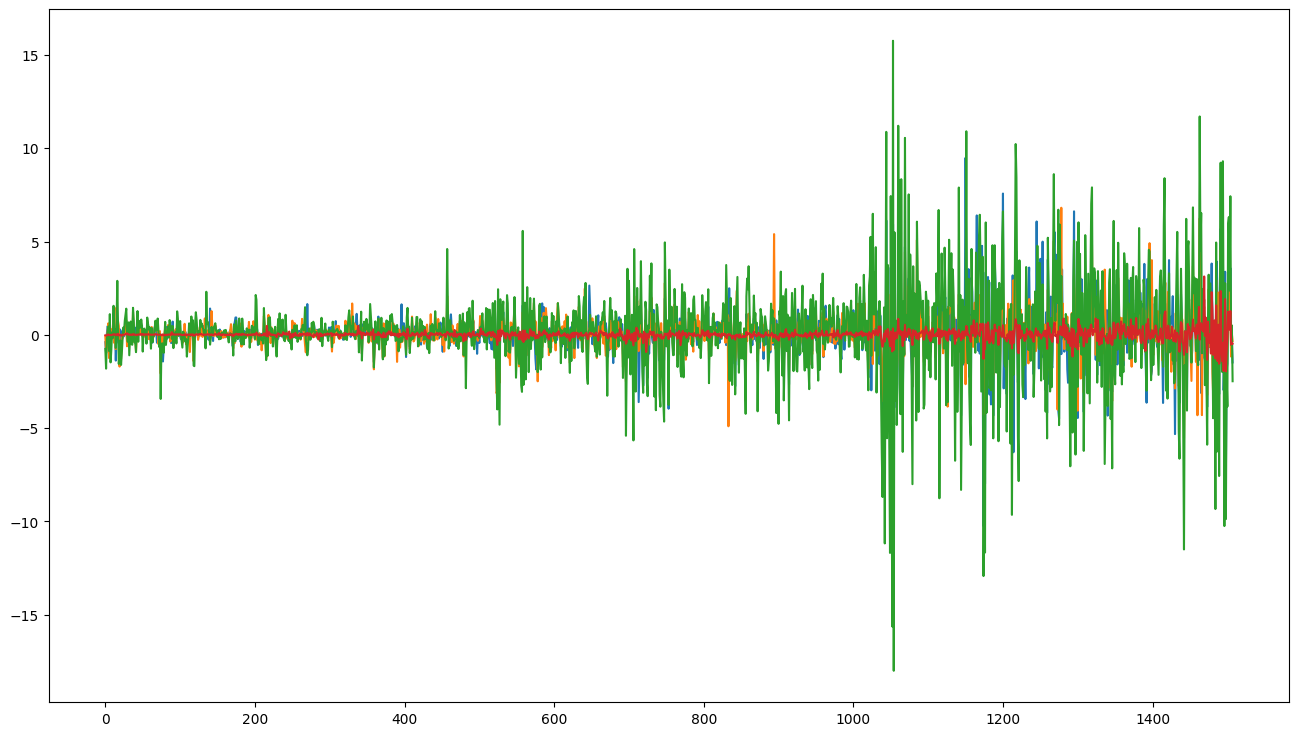

In [14]:
# Residuals 

plt.plot(vecm_model.resid, label="VECM residuals")

### 3.6. Damage
It looks like the variance depends on time. The kurtosis show an excess kurtosis of 10.844 meaning that the long-run relation exhibits fat tails.

6. Damage (Model Limitations)

> Volatility Clustering (ARCH effects in residuals) <br>
> Structural Breaks ( 2020 COVID shock) <br>


### 3.7. Directions
These issues might be resolve by stabilising variance with a log transforamtion of the series. When doing that on our data set, the Johansen test results shows and absence of cointegration between log series, despite the are I(1). In that situation, a VAR model on the first difference is more suitable to model the log series.


> GARCH-VECM: Model volatility explicitly <br>
> Regime-Switching VECM: Capture structural breaks <br>
> Shorter Time Window: Reduce impact of regime shifts

### 3.8. Deployment

> Pairs Trading: <br>
>> When equilibrium deviation > 1.5σ, short GOOGL and buy hedge portfolio (0.85 AAPL + 0.32 MSFT + 0.15 NVDA) <br>
>>Close position when spread reverts to mean.

>Risk Management:<br>
>>Monitor equilibrium for regime shifts.<br>
>>Hedge tech exposure during large deviations.<br>

>Asset Allocation<br>
>>Dynamic weights based on rolling β.<br>
>>Rebalance when equilibrium breaks down.<br>

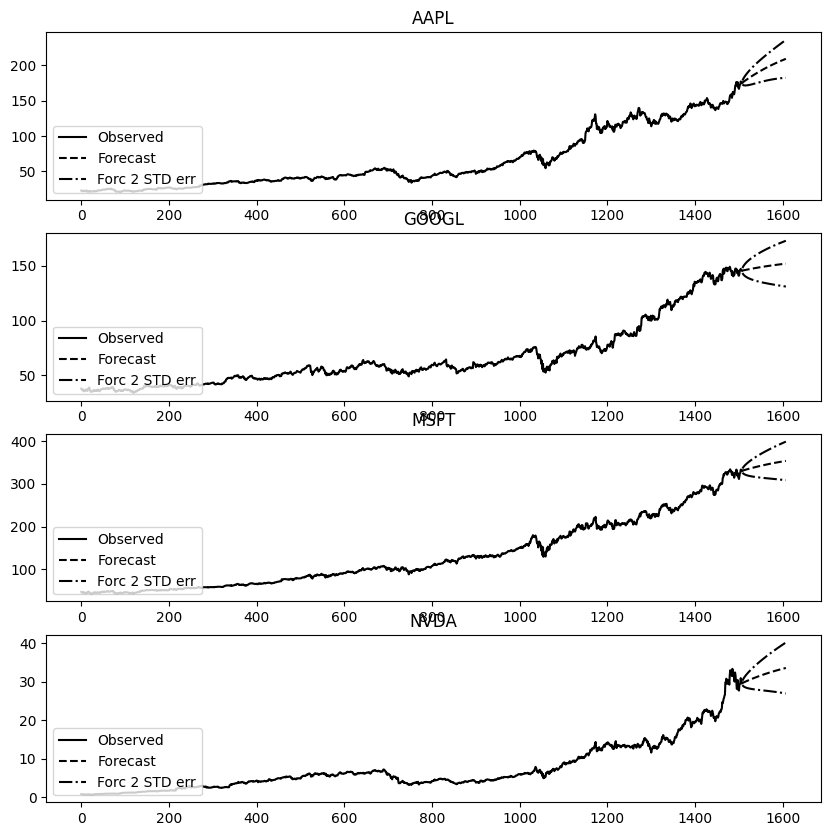

In [15]:
# Forcast
vecm_model.plot_forecast(100)

In [16]:
# Assuming vecm_model is your fitted VECM model
long_run_equilibrium = (
    vecm_model.const_coint[0][0] +
    vecm_model.beta[0][0] * data["AAPL"] +
    vecm_model.beta[1][0] * data["GOOGL"] +
    vecm_model.beta[2][0] * data["MSFT"] +
    vecm_model.beta[3][0] * data["NVDA"]
)

# Normalized equilibrium (mean = 0, std = 1)
equilibrium_z = (long_run_equilibrium - long_run_equilibrium.mean()) / long_run_equilibrium.std()

In [17]:
class CointegrationTradingStrategy:
    def __init__(self, data, beta, const, lookback=63, entry_z=1.5, exit_z=0.5):
        """
        Initialize the cointegration trading strategy.
        
        Parameters:
        - data: DataFrame of asset prices (columns: ['AAPL', 'GOOGL', 'MSFT', 'NVDA'])
        - beta: List of cointegration coefficients
        - const: Constant term from cointegration relationship
        - lookback: Rolling window size for statistics (default 63 trading days ~ 3 months)
        - entry_z: Z-score threshold for entering trades (default 1.5)
        - exit_z: Z-score threshold for exiting trades (default 0.5)
        """
        self.data = data.dropna().copy()
        self.beta = np.array(beta)
        self.const = const
        self.lookback = max(lookback, 20)  # Minimum 20 periods for stability
        self.entry_z = entry_z
        self.exit_z = exit_z

        if len(beta) != len(data.columns):
            raise ValueError("Number of beta coefficients must match data columns")

    def calculate_spread(self):
        """Calculate the cointegration spread using the VECM coefficients"""
        spread = np.full(len(self.data), self.const)
        for i, ticker in enumerate(self.data.columns):
            spread += self.beta[i] * self.data[ticker].values
        return pd.Series(spread, index=self.data.index, name='spread')

    def generate_signals(self):
        """
        Generate trading signals based on z-score thresholds.
        
        Returns:
        - DataFrame with columns: ['position', 'spread', 'z_score']
        """
        spread = self.calculate_spread()
        
        # Calculate rolling statistics with minimum periods
        mean = spread.rolling(self.lookback, min_periods=10).mean()
        std = spread.rolling(self.lookback, min_periods=10).std()
        z_score = ((spread - mean) / std).fillna(0)

        signals = pd.DataFrame(index=self.data.index, 
                             columns=['position', 'spread', 'z_score'])
        position = 0

        for i in range(1, len(self.data)):
            if i < self.lookback:
                signals.iloc[i] = [0, spread.iloc[i], z_score.iloc[i]]
                continue

            # Exit conditions first (important for realistic execution)
            if position != 0:
                if (position == -1 and z_score.iloc[i] < self.exit_z) or \
                   (position == 1 and z_score.iloc[i] > -self.exit_z):
                    position = 0

            # Entry conditions
            if position == 0:
                if z_score.iloc[i] > self.entry_z:
                    position = -1  # Short spread (buy hedge, sell tech)
                elif z_score.iloc[i] < -self.entry_z:
                    position = 1   # Long spread (sell hedge, buy tech)

            signals.iloc[i] = [position, spread.iloc[i], z_score.iloc[i]]

        return signals.dropna()

    def backtest(self, initial_capital=100000, risk_pct=0.01, tcost_bps=5):
        """
        Backtest the trading strategy with realistic assumptions.
        
        Parameters:
        - initial_capital: Starting capital (default $100,000)
        - risk_pct: Percentage of capital to risk per trade (default 1%)
        - tcost_bps: Transaction cost in basis points (default 5bps)
        
        Returns:
        - portfolio: DataFrame with performance metrics
        - signals: DataFrame with trading signals
        """
        signals = self.generate_signals()
        aligned_data = self.data.loc[signals.index]

        portfolio = pd.DataFrame(index=signals.index,
                               columns=['value', 'returns', 'drawdown', 'position'])
        portfolio.iloc[0] = [initial_capital, 0, 0, 0]

        peak = initial_capital  # Track peak for drawdown calculation

        for i in range(1, len(signals)):
            current_position = signals['position'].iloc[i]
            prev_position = portfolio['position'].iloc[i-1]
            prev_value = portfolio['value'].iloc[i-1]

            # Calculate dollar weights based on cointegration relationship
            tech_dollar = self.beta[0] * aligned_data['AAPL'].iloc[i] + \
                          self.beta[1] * aligned_data['GOOGL'].iloc[i]
            hedge_dollar = self.beta[2] * aligned_data['MSFT'].iloc[i] + \
                           self.beta[3] * aligned_data['NVDA'].iloc[i]
            total_dollar = abs(tech_dollar) + abs(hedge_dollar)

            # Position sizing with risk management
            risk_amount = prev_value * risk_pct
            position_size = min(risk_amount / (signals['spread'].std() + 1e-6),  # Avoid division by zero
                              prev_value * 0.5)  # Cap at 50% of capital

            # Calculate weighted returns
            tech_ret = (aligned_data[['AAPL', 'GOOGL']].pct_change().iloc[i].values @ self.beta[:2])
            hedge_ret = (aligned_data[['MSFT', 'NVDA']].pct_change().iloc[i].values @ self.beta[2:])
            strategy_ret = current_position * position_size * (tech_ret - hedge_ret)

            # Transaction costs (only applied when position changes)
            tcost = abs(current_position - prev_position) * position_size * (tcost_bps / 10000)

            # Update portfolio values
            new_value = prev_value + strategy_ret - tcost
            peak = max(peak, new_value)  # Update peak value
            
            portfolio.iloc[i] = [
                new_value,
                (new_value - prev_value) / prev_value,  # Daily return
                (peak - new_value) / peak,             # Current drawdown
                current_position
            ]

        return portfolio, signals

    def calculate_performance_metrics(self, portfolio):
        """Calculate key performance metrics from backtest results"""
        returns = portfolio['returns']
        total_return = portfolio['value'].iloc[-1] / portfolio['value'].iloc[0] - 1
        annualized_return = (1 + total_return) ** (252/len(portfolio)) - 1
        volatility = returns.std() * np.sqrt(252)
        sharpe_ratio = annualized_return / volatility
        max_drawdown = portfolio['drawdown'].max()
        
        return {
            'Total Return': total_return,
            'Annualized Return': annualized_return,
            'Annualized Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Calmar Ratio': annualized_return / max_drawdown if max_drawdown != 0 else np.nan
        }

In [18]:
# Extract coefficients from VECM
beta_coefficients = [vecm_model.beta[i][0] for i in range(4)]
const_term = vecm_model.const_coint[0][0]

# Initialize and run strategy
strategy = CointegrationTradingStrategy(
    data=data[['AAPL', 'GOOGL', 'MSFT', 'NVDA']],
    beta=beta_coefficients,
    const=const_term,
    lookback=63,      # 3-month rolling window
    entry_z=1.5,      # 1.5 standard deviation entry
    exit_z=0.05        # 0.5 standard deviation exit
)

portfolio,signals = strategy.backtest(risk_pct=.1)

In [19]:
def analyze_performance(portfolio):
    returns = portfolio['returns']
    
    metrics = {
        'Total Return': portfolio['value'].iloc[-1] / portfolio['value'].iloc[0] - 1,
        'Annualized Return': np.mean(returns) * 252,
        'Annualized Volatility': np.std(returns) * np.sqrt(252),
        'Sharpe Ratio': np.mean(returns) / np.std(returns) * np.sqrt(252),
        'Max Drawdown': portfolio['drawdown'].max(),
        'Win Rate': (returns > 0).mean(),
        'Profit Factor': returns[returns > 0].sum() / (1e-10 + abs(returns[returns < 0].sum()))
    }
    
    return pd.Series(metrics)

performance = analyze_performance(portfolio)
print(performance)

Total Return             0.023979
Annualized Return        0.004157
Annualized Volatility    0.020013
Sharpe Ratio             0.207735
Max Drawdown             0.060447
Win Rate                 0.332671
Profit Factor            1.048591
dtype: float64


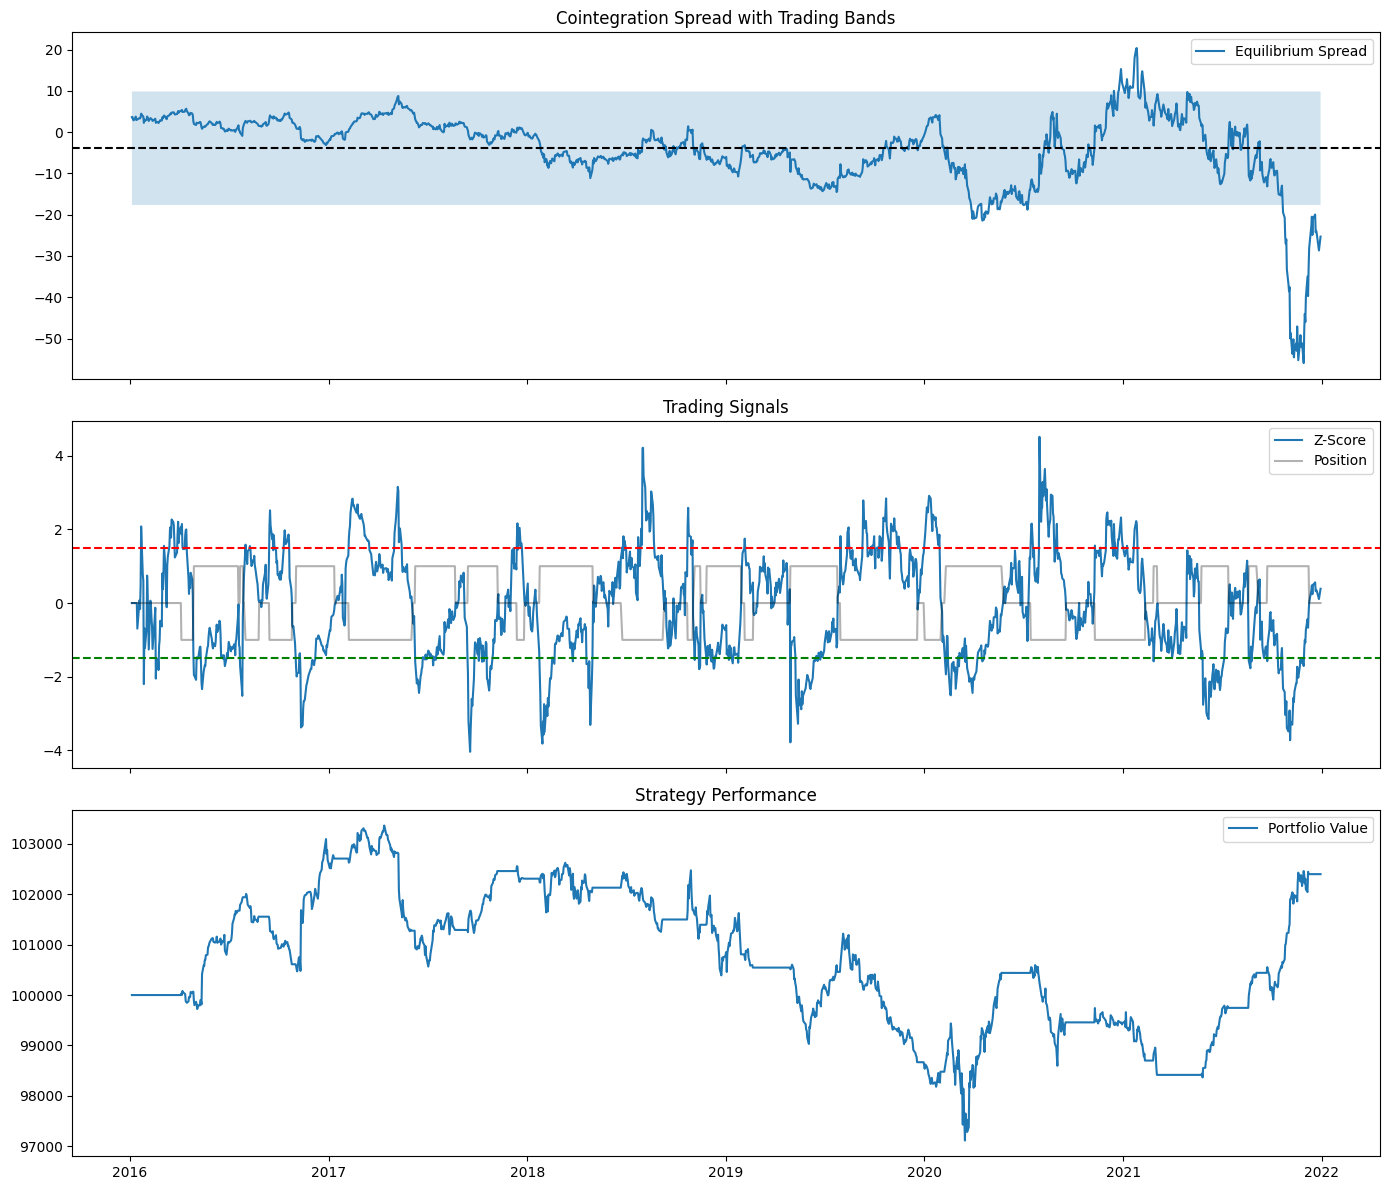

In [20]:
def plot_strategy(portfolio, signals):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    # Equilibrium spread
    ax1.plot(signals['spread'], label='Equilibrium Spread')
    ax1.axhline(signals['spread'].mean(), color='k', linestyle='--')
    ax1.fill_between(signals.index,
                     signals['spread'].mean() - 1.5*signals['spread'].std(),
                     signals['spread'].mean() + 1.5*signals['spread'].std(),
                     alpha=0.2)
    ax1.set_title('Cointegration Spread with Trading Bands')
    ax1.legend()
    
    # Z-score with positions
    ax2.plot(signals['z_score'], label='Z-Score')
    ax2.axhline(1.5, color='r', linestyle='--')
    ax2.axhline(-1.5, color='g', linestyle='--')
    ax2.plot(signals['position'], 'k-', alpha=0.3, label='Position')
    ax2.set_title('Trading Signals')
    ax2.legend()
    
    # Portfolio value
    ax3.plot(portfolio['value'], label='Portfolio Value')
    ax3.set_title('Strategy Performance')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

plot_strategy(portfolio, signals)